<a href="https://colab.research.google.com/github/George-Okello/XAI/blob/main/explainable_AI_(XAI)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap pandas scikit-learn matplotlib seaborn ucimlrepo


In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [3]:
# fetch dataset
statlog_heart = fetch_ucirepo(id=145)

# data (as pandas dataframes)
X = statlog_heart.data.features
y = statlog_heart.data.targets['heart-disease']

# metadata
display(statlog_heart.metadata)

# variable information
display(statlog_heart.variables)


{'uci_id': 145,
 'name': 'Statlog (Heart)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/145/statlog+heart',
 'data_url': 'https://archive.ics.uci.edu/static/public/145/data.csv',
 'abstract': 'This dataset is a heart disease database similar to a database already present in the repository (Heart Disease databases) but in a slightly different form',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 270,
 'num_features': 13,
 'feature_types': ['Categorical', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['heart-disease'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': None,
 'last_updated': 'Fri Feb 09 2024',
 'dataset_doi': '10.24432/C57303',
 'creators': [],
 'intro_paper': None,
 'additional_info': {'summary': 'Cost Matrix\r\n\r\n_______\t abse  pres\r\nabsence\t 0\t1\r\npresence  5\t0\r\n\r\nwhere the rows represent the true values 

name     role         type demographic  \
0                    age  Feature   Continuous         Age   
1                    sex  Feature       Binary         Sex   
2             chest-pain  Feature  Categorical        None   
3                rest-bp  Feature   Continuous        None   
4             serum-chol  Feature   Continuous        None   
5    fasting-blood-sugar  Feature       Binary        None   
6   electrocardiographic  Feature  Categorical        None   
7         max-heart-rate  Feature   Continuous        None   
8                 angina  Feature       Binary        None   
9                oldpeak  Feature   Continuous        None   
10                 slope  Feature      Integer        None   
11         major-vessels  Feature   Continuous        None   
12                  thal  Feature  Categorical        None   
13         heart-disease   Target      Integer        None   

                                          description  units missing_values  
0                                                None   None             no  
1                                                None   None             no  
2                                     chest pain type   None             no  
3                              resting blood pressure   None             no  
4                                   serum cholesterol  mg/dl             no  
5                     fasting blood sugar > 120 mg/dl   None             no  
6                resting electrocardiographic results   None             no  
7                         maximum heart rate achieved   None             no  
8                             exercise induced anigna   None             no  
9   oldpeak = ST depression induced by exercise re...   None             no  
10           the slope of the peak exercise ST sgment   None             no  
11  number of major vessels (0-3) colored by fluor...   None             no  
12  thal: 3 = normal; 6 = fixed defect; 7 = revers...   None             no  
13                                               None   None             no

In [4]:
# Convert target from 1/2 → 0/1
y = y.replace({1: 0, 2: 1})
y

0      1
1      0
2      1
3      0
4      0
      ..
265    0
266    0
267    0
268    0
269    1
Name: heart-disease, Length: 270, dtype: int64

In [5]:
# Convert categorical features to dummy variables
X_encoded = pd.get_dummies(X, drop_first=True)

print("Shape after encoding:", X_encoded.shape)


Shape after encoding: (270, 13)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Apply Random Oversampling to balance the training set
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Train a decision tree
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.80      0.84        45
           1       0.78      0.86      0.82        36

    accuracy                           0.83        81
   macro avg       0.83      0.83      0.83        81
weighted avg       0.83      0.83      0.83        81



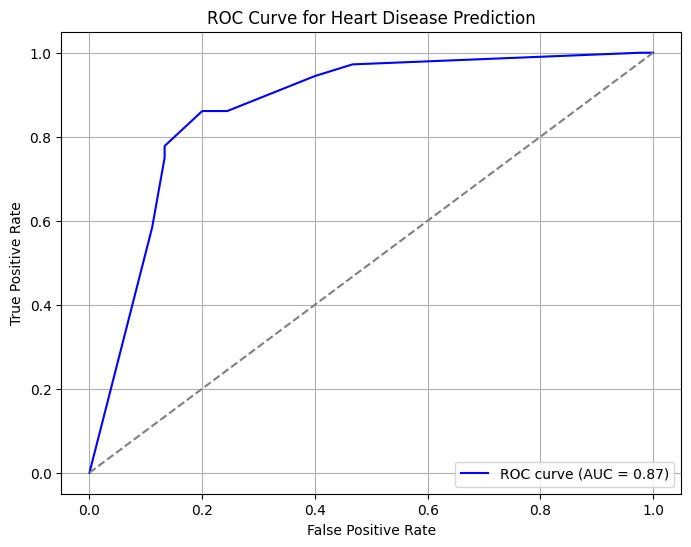

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


This means the model is reasonably good but not perfect, especially in identifying people with heart disease. This makes explanations important — we need to understand how the model decides, especially for risky or false predictions

Class 1 SHAP values shape: (81, 13)


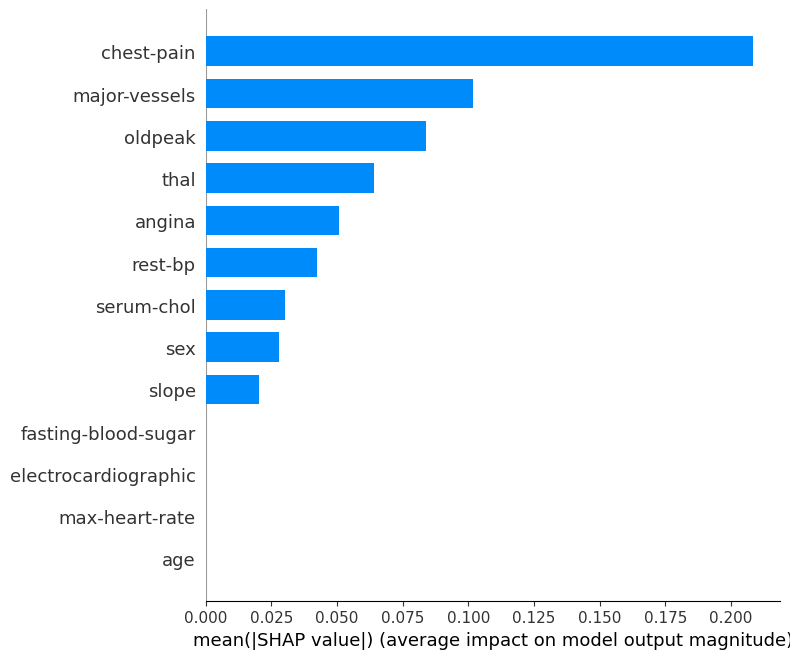

In [8]:
import shap
import numpy as np

# If you're using a TreeExplainer:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# ✅ Correct way for summary bar plot for binary classification:
# shap_values[1] if you're interested in class 1 (heart disease present)
shap_values_class1 = np.array([sample[:, 1] for sample in shap_values])
print("Class 1 SHAP values shape:", shap_values_class1.shape)  # Should be (81, 13)

# Now create the summary plot
shap.summary_plot(shap_values_class1, X_test, plot_type="bar")


thal: Availability Heuristic – thalassemia is rare but heavily weighted.
chest-pain: Framing Effect – pain framed as severe may bias decisions.
oldpeak: Anchoring Bias – decisions anchored to initial ST depression value.
angina: Representativeness Heuristic – classic symptoms bias diagnosis.
max-heart-rate: Affect Heuristic – emotional response to high/low values.


In [9]:
import pandas as pd
import numpy as np

# First, let's see all column names
print("All columns in X_test:")
print(X_test.columns.tolist())
print(f"\nTotal columns: {len(X_test.columns)}")

# Look for thal-related columns with different patterns
print("\n" + "="*50)
print("Searching for thal-related columns:")
print("="*50)

# Try different search patterns
thal_patterns = ['thal', 'Thal', 'THAL', 'tal', 'defect']
for pattern in thal_patterns:
    matching_cols = [col for col in X_test.columns if pattern in col]
    if matching_cols:
        print(f"Columns containing '{pattern}': {matching_cols}")

# Check if there's a single 'thal' column (not one-hot encoded)
if 'thal' in X_test.columns:
    print(f"\nFound 'thal' column!")
    print(f"Unique values in thal: {sorted(X_test['thal'].unique())}")
    print(f"Value counts:\n{X_test['thal'].value_counts().sort_index()}")
elif 'Thal' in X_test.columns:
    print(f"\nFound 'Thal' column!")
    print(f"Unique values in Thal: {sorted(X_test['Thal'].unique())}")
    print(f"Value counts:\n{X_test['Thal'].value_counts().sort_index()}")
else:
    print("\nNo direct 'thal' column found.")

    # Let's look at the last few columns (thal is often the last feature)
    print(f"\nLast 5 columns: {X_test.columns[-5:].tolist()}")

    # Show sample of data to help identify the pattern
    print(f"\nFirst few rows of data:")
    print(X_test.head())

    # Look for categorical columns that might be thal
    print(f"\nColumns with limited unique values (potential categorical):")
    for col in X_test.columns:
        unique_vals = X_test[col].nunique()
        if unique_vals <= 5:  # Likely categorical
            print(f"{col}: {unique_vals} unique values - {sorted(X_test[col].unique())}")

# Check if there are numbered columns that might be one-hot encoded features
print(f"\n" + "="*50)
print("Checking for numbered columns (possible one-hot encoding):")
print("="*50)

numbered_cols = [col for col in X_test.columns if any(char.isdigit() for char in str(col))]
if numbered_cols:
    print(f"Columns with numbers: {numbered_cols}")

    # Group by base name
    base_names = {}
    for col in numbered_cols:
        base = ''.join([c for c in col if not c.isdigit() and c != '_'])
        if base not in base_names:
            base_names[base] = []
        base_names[base].append(col)

    for base, cols in base_names.items():
        if len(cols) > 1:
            print(f"Potential one-hot group '{base}': {cols}")

# If we still haven't found thal, let's check the original dataset structure
print(f"\n" + "="*50)
print("Dataset Info:")
print("="*50)
print(f"Shape: {X_test.shape}")
print(f"Data types:\n{X_test.dtypes}")

# Common heart disease dataset column patterns
common_heart_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                     'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

print(f"\nChecking for common heart disease dataset columns:")
for col in common_heart_cols:
    if col in X_test.columns:
        print(f"✓ {col} found")
    else:
        # Check for partial matches
        partial_matches = [c for c in X_test.columns if col in c.lower()]
        if partial_matches:
            print(f"~ {col} partial matches: {partial_matches}")
        else:
            print(f"✗ {col} not found")

All columns in X_test:
['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'fasting-blood-sugar', 'electrocardiographic', 'max-heart-rate', 'angina', 'oldpeak', 'slope', 'major-vessels', 'thal']

Total columns: 13

Searching for thal-related columns:
Columns containing 'thal': ['thal']

Found 'thal' column!
Unique values in thal: [np.float64(3.0), np.float64(6.0), np.float64(7.0)]
Value counts:
thal
3.0    42
6.0     5
7.0    34
Name: count, dtype: int64

Checking for numbered columns (possible one-hot encoding):

Dataset Info:
Shape: (81, 13)
Data types:
age                     float64
sex                     float64
chest-pain              float64
rest-bp                 float64
serum-chol              float64
fasting-blood-sugar     float64
electrocardiographic    float64
max-heart-rate          float64
angina                  float64
oldpeak                 float64
slope                   float64
major-vessels           float64
thal                    float64
dtype: object

Check

In [10]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Set up the plotting style
plt.style.use('default')  # More Jupyter-friendly than seaborn
sns.set_palette("husl")


In [11]:
# Custom color palette
colors = {
    'normal': '#2E86AB',      # Blue
    'reversible': '#A23B72',  # Purple
    'accent': '#F18F01',      # Orange
    'text': '#2D3436'         # Dark gray
}

def create_custom_shap_plot(shap_values, X_data, title, color, figsize=(12, 8)):
    """Create a custom SHAP bar plot with better styling for Jupyter"""

    # Calculate mean absolute SHAP values
    mean_shap = np.abs(shap_values).mean(axis=0)

    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': X_data.columns,
        'importance': mean_shap
    }).sort_values('importance', ascending=True)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')

    # Create horizontal bar plot
    y_pos = np.arange(len(feature_importance))
    bars = ax.barh(y_pos, feature_importance['importance'],
                   color=color, alpha=0.85, edgecolor='white', linewidth=1.5)

    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_importance['feature'], fontsize=11, fontweight='600')
    ax.set_xlabel('Mean |SHAP Value|', fontsize=13, fontweight='700', color=colors['text'])
    ax.set_title(title, fontsize=16, fontweight='800', pad=25, color=colors['text'])

    # Add value labels on bars
    max_val = feature_importance['importance'].max()
    for i, (bar, value) in enumerate(zip(bars, feature_importance['importance'])):
        width = bar.get_width()
        ax.text(width + max_val*0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center',
                fontsize=9, fontweight='600', color=colors['text'])

    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')
    ax.set_facecolor('#FAFAFA')

    # Sample size annotation
    ax.text(0.98, 0.02, f'n = {len(X_data)}',
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=color, alpha=0.2, edgecolor=color),
            fontsize=10, fontweight='600', color=colors['text'])

    plt.tight_layout()
    return fig, ax

print("✅ Custom plotting function defined!")

✅ Custom plotting function defined!


In [12]:
print("📊 Preparing data for SHAP analysis...")
print("="*50)

# Check thal column values and create subsets
print(f"Thal value distribution:")
thal_counts = X_test['thal'].value_counts().sort_index()
print(thal_counts)

# Create subsets
thal_3 = X_test[X_test['thal'] == 3.0]  # normal
thal_7 = X_test[X_test['thal'] == 7.0]  # reversible defect

print(f"\n📈 Sample sizes:")
print(f"• Normal (thal=3): {len(thal_3)} samples")
print(f"• Reversible Defect (thal=7): {len(thal_7)} samples")

if len(thal_3) == 0 or len(thal_7) == 0:
    print("⚠️ Warning: One of the groups is empty!")

print("✅ Data preparation complete!")

📊 Preparing data for SHAP analysis...
Thal value distribution:
thal
3.0    42
6.0     5
7.0    34
Name: count, dtype: int64

📈 Sample sizes:
• Normal (thal=3): 42 samples
• Reversible Defect (thal=7): 34 samples
✅ Data preparation complete!


In [13]:
print("🔄 Computing SHAP values...")

try:
    # Compute SHAP values for each subset
    print("Computing SHAP for normal thalassemia...")
    shap_values_3 = explainer.shap_values(thal_3)

    print("Computing SHAP for reversible defect...")
    shap_values_7 = explainer.shap_values(thal_7)

    # Convert to class 1 (heart disease) SHAP values
    shap_values_3_class1 = np.array([sample[:, 1] for sample in shap_values_3])
    shap_values_7_class1 = np.array([sample[:, 1] for sample in shap_values_7])

    print(f"✅ SHAP computation complete!")
    print(f"• Normal group SHAP shape: {shap_values_3_class1.shape}")
    print(f"• Reversible defect SHAP shape: {shap_values_7_class1.shape}")

except Exception as e:
    print(f"❌ Error computing SHAP values: {e}")
    print("Make sure 'explainer' is defined in your environment")

🔄 Computing SHAP values...
Computing SHAP for normal thalassemia...
Computing SHAP for reversible defect...
✅ SHAP computation complete!
• Normal group SHAP shape: (42, 13)
• Reversible defect SHAP shape: (34, 13)


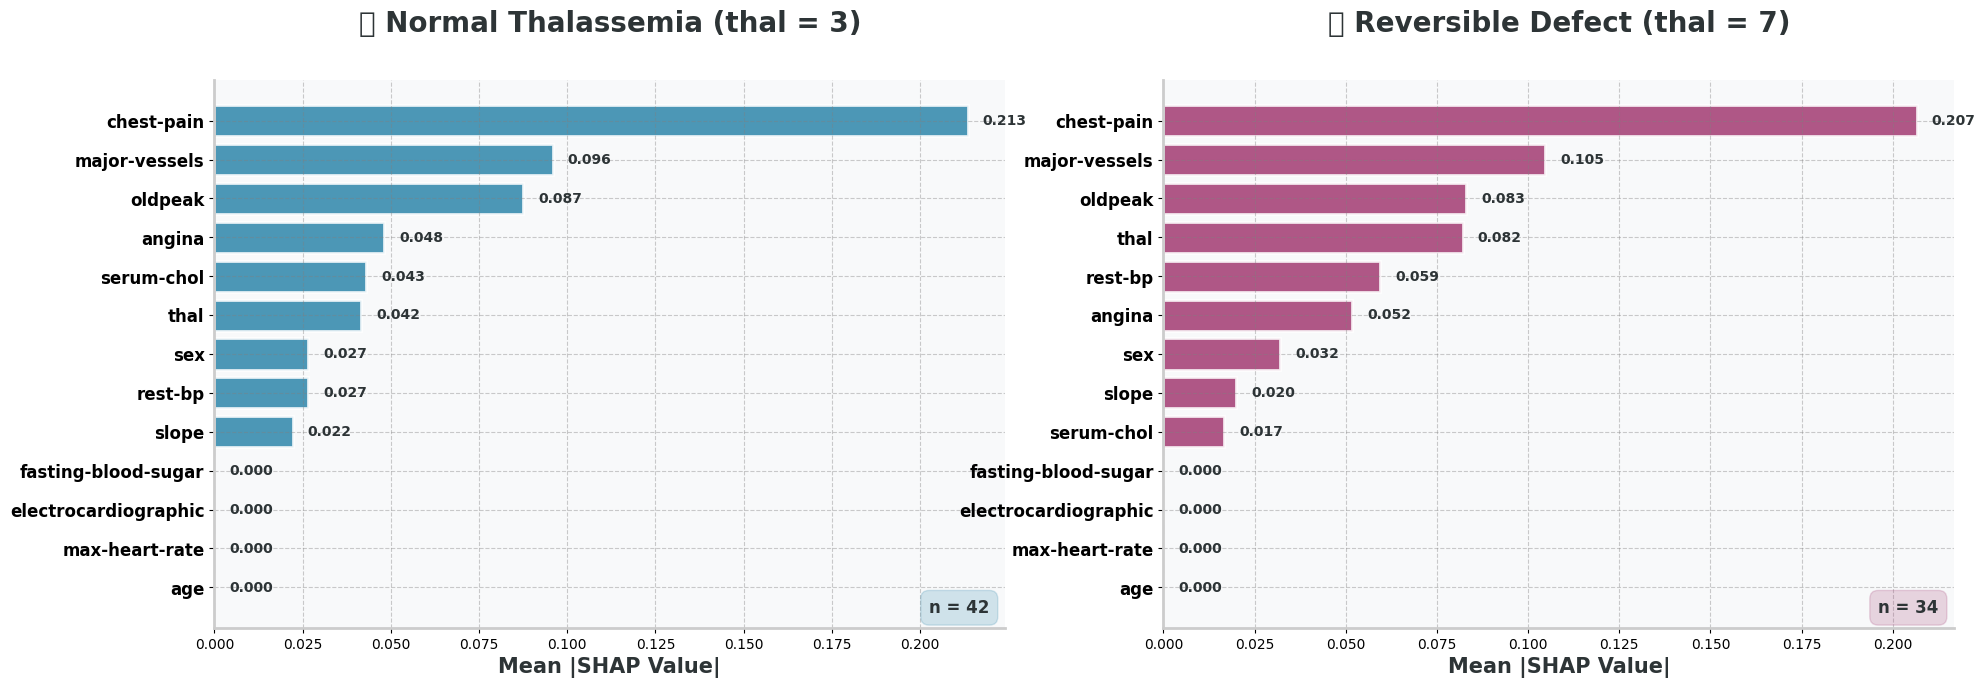

In [14]:
def plot_enhanced_shap(ax, shap_values, X_data, title, color):
    mean_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'feature': X_data.columns,
        'importance': mean_shap
    }).sort_values('importance', ascending=True)

    y_pos = np.arange(len(feature_importance))
    bars = ax.barh(y_pos, feature_importance['importance'],
                   color=color, alpha=0.85, edgecolor='white', linewidth=2)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_importance['feature'], fontsize=12, fontweight='600')
    ax.set_xlabel('Mean |SHAP Value|', fontsize=15, fontweight='700', color=colors['text'])
    ax.set_title(title, fontsize=20, fontweight='800', pad=35, color=colors['text'])

    max_val = feature_importance['importance'].max()
    for i, (bar, value) in enumerate(zip(bars, feature_importance['importance'])):
        width = bar.get_width()
        ax.text(width + max_val*0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center',
                fontsize=10, fontweight='600', color=colors['text'])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.grid(True, alpha=0.4, linestyle='--', color='gray')
    ax.set_facecolor('#F8F9FA')

    ax.text(0.98, 0.02, f'n = {len(X_data)}',
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.2, edgecolor=color),
            fontsize=12, fontweight='600', color=colors['text'])

# Create figure layout
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], hspace=0.4, wspace=0.2,
                      top=0.88, bottom=0.15, left=0.08, right=0.95)

# Add plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plot_enhanced_shap(ax1, shap_values_3_class1, thal_3,
                   '🫀 Normal Thalassemia (thal = 3)', colors['normal'])

plot_enhanced_shap(ax2, shap_values_7_class1, thal_7,
                   '💔 Reversible Defect (thal = 7)', colors['reversible'])


In [15]:
print("\n📋 Creating feature importance comparison table...")

# Create feature comparison
mean_shap_3 = np.abs(shap_values_3_class1).mean(axis=0)
mean_shap_7 = np.abs(shap_values_7_class1).mean(axis=0)

comparison_df = pd.DataFrame({
    'Feature': thal_3.columns,
    'Normal_Importance': mean_shap_3,
    'Reversible_Defect_Importance': mean_shap_7,
    'Difference': mean_shap_7 - mean_shap_3,
    'Ratio': mean_shap_7 / (mean_shap_3 + 1e-10)
}).sort_values('Difference', key=abs, ascending=False)

print("🔍 Top Feature Differences (Reversible Defect vs Normal):")
print("="*65)

# Display formatted table
display_df = comparison_df.round(4).head(8)
display_df['Difference'] = display_df['Difference'].apply(lambda x: f"{x:+.4f}")
display_df['Ratio'] = display_df['Ratio'].apply(lambda x: f"{x:.2f}x")

print(display_df.to_string(index=False))

print("\n💡 Interpretation:")
print("• Positive difference: More important for reversible defect")
print("• Negative difference: More important for normal thalassemia")
print("• Ratio > 1: Feature is more important for reversible defect")


📋 Creating feature importance comparison table...
🔍 Top Feature Differences (Reversible Defect vs Normal):
      Feature  Normal_Importance  Reversible_Defect_Importance Difference Ratio
         thal             0.0416                        0.0821    +0.0404 1.97x
      rest-bp             0.0265                        0.0595    +0.0329 2.24x
   serum-chol             0.0430                        0.0167    -0.0264 0.39x
major-vessels             0.0959                        0.1047    +0.0088 1.09x
   chest-pain             0.2135                        0.2066    -0.0069 0.97x
          sex             0.0266                        0.0320    +0.0054 1.20x
      oldpeak             0.0875                        0.0830    -0.0045 0.95x
       angina             0.0482                        0.0517    +0.0035 1.07x

💡 Interpretation:
• Positive difference: More important for reversible defect
• Negative difference: More important for normal thalassemia
• Ratio > 1: Feature is more imp


📊 Creating individual detailed plots...
Creating plot for Normal Thalassemia...


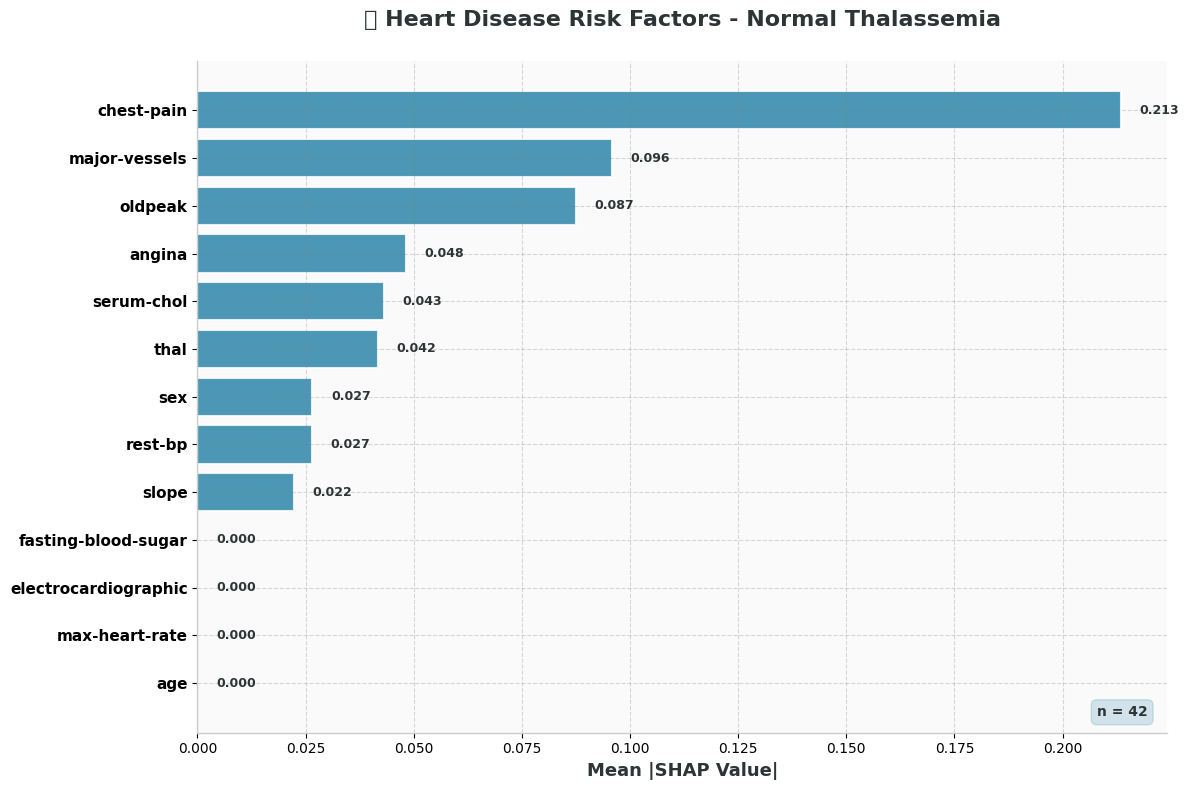

Creating plot for Reversible Defect...


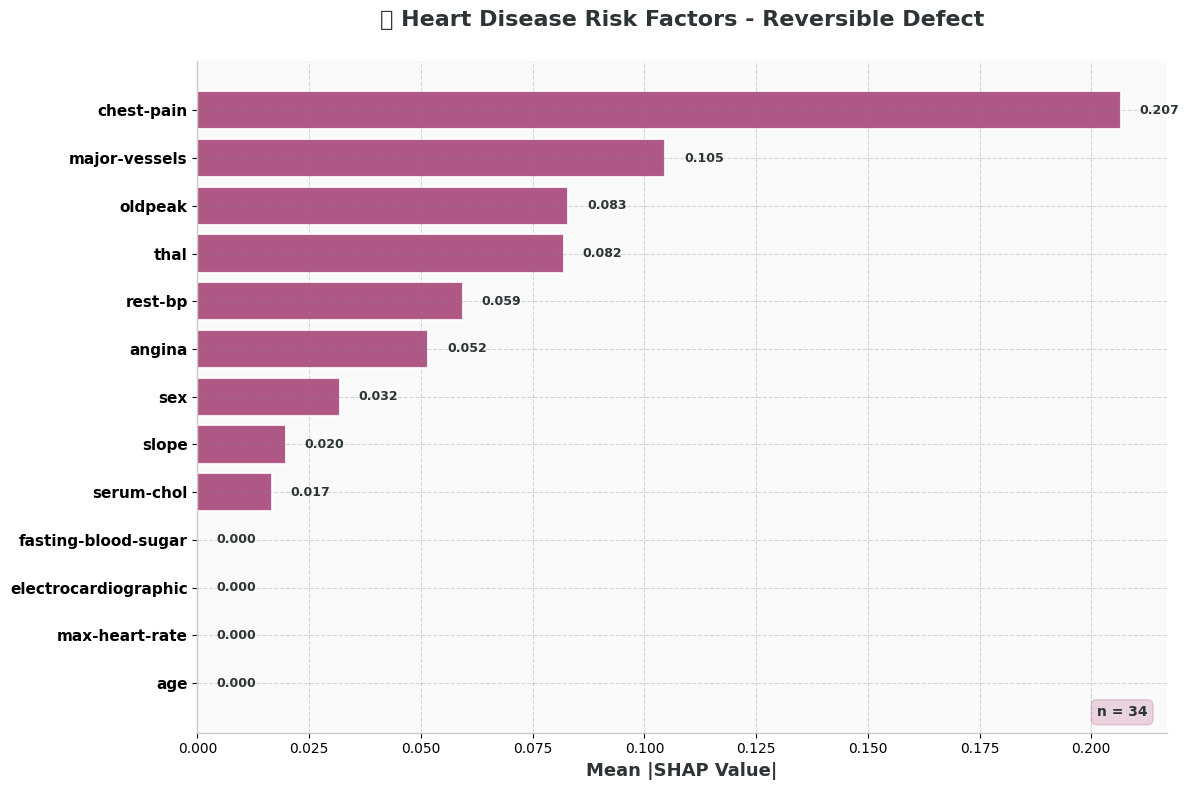

In [16]:
print("\n📊 Creating individual detailed plots...")

# Individual plot for Normal
print("Creating plot for Normal Thalassemia...")
fig1, ax1 = create_custom_shap_plot(shap_values_3_class1, thal_3,
                                   '🫀 Heart Disease Risk Factors - Normal Thalassemia',
                                   colors['normal'])
plt.show()

# Individual plot for Reversible Defect
print("Creating plot for Reversible Defect...")
fig2, ax2 = create_custom_shap_plot(shap_values_7_class1, thal_7,
                                   '💔 Heart Disease Risk Factors - Reversible Defect',
                                   colors['reversible'])
plt.show()

In [17]:
print(f"\n📈 Dataset Summary:")
print(f"• Total samples: {len(X_test)}")
print(f"• Normal thalassemia: {len(thal_3)} samples ({len(thal_3)/len(X_test)*100:.1f}%)")
print(f"• Reversible defect: {len(thal_7)} samples ({len(thal_7)/len(X_test)*100:.1f}%)")

# Find top 3 most different features
top_features = comparison_df.head(3)
print(f"\n🔍 Top 3 Most Different Features:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"{i}. {row['Feature']}: {abs(row['Difference']):.4f} {direction} importance for reversible defect")



📈 Dataset Summary:
• Total samples: 81
• Normal thalassemia: 42 samples (51.9%)
• Reversible defect: 34 samples (42.0%)

🔍 Top 3 Most Different Features:
1. thal: 0.0404 higher importance for reversible defect
2. rest-bp: 0.0329 higher importance for reversible defect
3. serum-chol: 0.0264 lower importance for reversible defect


In [18]:
!pip install lime

import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("✅ LIME installed and imported successfully!")


✅ LIME installed and imported successfully!


In [19]:
print("🔧 Initializing LIME explainer...")

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Disease', 'Disease'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("✅ LIME explainer initialized!")
print(f"📊 Training data shape: {X_train.shape}")
print(f"🏷️ Feature names: {list(X_train.columns)}")
print(f"🎯 Classes: ['No Disease', 'Disease']")

🔧 Initializing LIME explainer...
✅ LIME explainer initialized!
📊 Training data shape: (189, 13)
🏷️ Feature names: ['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'fasting-blood-sugar', 'electrocardiographic', 'max-heart-rate', 'angina', 'oldpeak', 'slope', 'major-vessels', 'thal']
🎯 Classes: ['No Disease', 'Disease']


In [20]:
print("\n🔍 Explaining individual predictions...")

def explain_single_instance(instance_idx, show_plot=True):
    """Explain a single instance with LIME"""

    # Get the instance
    instance = X_test.iloc[instance_idx]

    # Get model prediction
    prediction_proba = model.predict_proba([instance])[0]
    prediction = model.predict([instance])[0]

    print(f"📋 Instance {instance_idx} Details:")
    print(f"• Prediction: {'Disease' if prediction == 1 else 'No Disease'}")
    print(f"• Confidence: {max(prediction_proba):.3f}")
    print(f"• Probabilities: No Disease={prediction_proba[0]:.3f}, Disease={prediction_proba[1]:.3f}")

    # Create LIME explanation
    exp = lime_explainer.explain_instance(
        instance,
        model.predict_proba,
        num_features=len(X_train.columns),
        top_labels=2
    )

    if show_plot:
        # Show in notebook
        exp.show_in_notebook(show_table=True, show_all=False)

    return exp, instance, prediction_proba



🔍 Explaining individual predictions...


In [21]:
print("\n📊 Analyzing multiple instances...")

def analyze_multiple_instances(indices_list, thal_type_name=""):
    """Analyze multiple instances and create summary"""

    results = []

    for idx in indices_list:
        try:
            instance = X_test.iloc[idx]
            prediction_proba = model.predict_proba([instance])[0]
            prediction = model.predict([instance])[0]

            # Get LIME explanation
            exp = lime_explainer.explain_instance(
                instance,
                model.predict_proba,
                num_features=len(X_train.columns)
            )

            # Extract feature importance from LIME
            lime_values = dict(exp.as_list())

            results.append({
                'index': idx,
                'prediction': prediction,
                'disease_prob': prediction_proba[1],
                'lime_explanation': lime_values,
                'instance': instance
            })

        except Exception as e:
            print(f"⚠️ Error analyzing instance {idx}: {e}")

    print(f"✅ Analyzed {len(results)} instances for {thal_type_name}")
    return results

# Analyze instances by thalassemia type
print("🔬 Analyzing by Thalassemia type...")

# Get indices for different thal types
thal_3_indices = X_test[X_test['thal'] == 3.0].index.tolist()[:5]  # First 5 normal
thal_7_indices = X_test[X_test['thal'] == 7.0].index.tolist()[:5]  # First 5 reversible

print(f"📈 Sample indices:")
print(f"• Normal thalassemia (3): {thal_3_indices}")
print(f"• Reversible defect (7): {thal_7_indices}")

# Analyze each group
normal_results = analyze_multiple_instances(thal_3_indices, "Normal Thalassemia")
reversible_results = analyze_multiple_instances(thal_7_indices, "Reversible Defect")


📊 Analyzing multiple instances...
🔬 Analyzing by Thalassemia type...
📈 Sample indices:
• Normal thalassemia (3): [96, 106, 167, 100, 253]
• Reversible defect (7): [159, 49, 3, 245, 158]
⚠️ Error analyzing instance 96: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 106: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 167: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 100: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 253: single positional indexer is out-of-bounds
✅ Analyzed 0 instances for Normal Thalassemia
⚠️ Error analyzing instance 159: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 245: single positional indexer is out-of-bounds
⚠️ Error analyzing instance 158: single positional indexer is out-of-bounds
✅ Analyzed 2 instances for Reversible Defect


In [22]:
print("\n🎨 Creating comprehensive LIME visualizations...")

def create_lime_comparison_plot(normal_results, reversible_results):
    """Create side-by-side LIME comparison plots"""

    # Aggregate LIME values
    def aggregate_lime_values(results):
        all_features = set()
        for result in results:
            all_features.update(result['lime_explanation'].keys())

        feature_importance = {}
        for feature in all_features:
            values = [result['lime_explanation'].get(feature, 0) for result in results]
            feature_importance[feature] = np.mean(values)

        return feature_importance

    normal_importance = aggregate_lime_values(normal_results)
    reversible_importance = aggregate_lime_values(reversible_results)

    # Prepare comparison DataFrame
    all_features = sorted(set(normal_importance) | set(reversible_importance))
    comparison_data = [{
        'Feature': feature,
        'Normal': normal_importance.get(feature, 0),
        'Reversible': reversible_importance.get(feature, 0)
    } for feature in all_features]

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df['Difference'] = comparison_df['Reversible'] - comparison_df['Normal']
    comparison_df = comparison_df.reindex(comparison_df['Difference'].abs().sort_values(ascending=False).index)

    # Create the plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('🧪 LIME Analysis: Feature Importance by Thalassemia Type',
                 fontsize=20, fontweight='bold', y=0.95)

    # ---------- Subplot 1: Normal ----------
    normal_df = comparison_df.nlargest(10, 'Normal')
    colors_normal = ['#2E86AB' if x >= 0 else '#E74C3C' for x in normal_df['Normal']]
    ax1.barh(normal_df['Feature'], normal_df['Normal'], color=colors_normal)
    ax1.set_title('🫀 Normal Thalassemia\nTop Features', fontsize=14, fontweight='bold')
    ax1.set_xlabel('LIME Importance')
    ax1.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax1.grid(alpha=0.3)

    # Value labels
    for i, v in enumerate(normal_df['Normal']):
        ax1.text(v + (0.01 if v >= 0 else -0.01), i, f'{v:.3f}',
                 va='center', ha='left' if v >= 0 else 'right', fontsize=9)

    # ---------- Subplot 2: Reversible ----------
    reversible_df = comparison_df.nlargest(10, 'Reversible')
    colors_reversible = ['#A23B72' if x >= 0 else '#E74C3C' for x in reversible_df['Reversible']]
    ax2.barh(reversible_df['Feature'], reversible_df['Reversible'], color=colors_reversible)
    ax2.set_title('💔 Reversible Defect\nTop Features', fontsize=14, fontweight='bold')
    ax2.set_xlabel('LIME Importance')
    ax2.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax2.grid(alpha=0.3)

    for i, v in enumerate(reversible_df['Reversible']):
        ax2.text(v + (0.01 if v >= 0 else -0.01), i, f'{v:.3f}',
                 va='center', ha='left' if v >= 0 else 'right', fontsize=9)

    # ---------- Subplot 3: Difference ----------
    diff_df = comparison_df.nlargest(10, 'Difference')
    colors_diff = ['#F18F01' if x >= 0 else '#3498DB' for x in diff_df['Difference']]
    ax3.barh(diff_df['Feature'], diff_df['Difference'], color=colors_diff)
    ax3.set_title('📊 Difference (Reversible - Normal)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Difference')
    ax3.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax3.grid(alpha=0.3)

    for i, v in enumerate(diff_df['Difference']):
        ax3.text(v + (0.01 if v >= 0 else -0.01), i, f'{v:.3f}',
                 va='center', ha='left' if v >= 0 else 'right', fontsize=9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    return comparison_df

# Execute comparison and display
if normal_results and reversible_results:
    comparison_df = create_lime_comparison_plot(normal_results, reversible_results)

    print("\n📋 Feature Importance Summary (Top 10)")
    print("=======================================")
    summary_df = comparison_df.head(10).copy()
    summary_df[['Normal', 'Reversible', 'Difference']] = summary_df[['Normal', 'Reversible', 'Difference']].round(4)
    print(summary_df[['Feature', 'Normal', 'Reversible', 'Difference']].to_string(index=False, justify='center'))



🎨 Creating comprehensive LIME visualizations...


In [23]:
print("\n🔍 Interactive Instance Explorer")
print("="*50)

def explore_specific_instances(thal_value, num_instances=3):
    """Explore specific instances by thal value"""

    thal_subset = X_test[X_test['thal'] == thal_value]

    if len(thal_subset) == 0:
        print(f"⚠️ No instances found with thal = {thal_value}")
        return

    print(f"🔬 Exploring {min(num_instances, len(thal_subset))} instances with thal = {thal_value}")

    for i, (idx, instance) in enumerate(thal_subset.head(num_instances).iterrows()):
        print(f"\n📊 Instance {i+1} (Index: {idx}):")
        print("-" * 40)

        # Get prediction
        prediction_proba = model.predict_proba([instance])[0]
        prediction = model.predict([instance])[0]

        print(f"🎯 Prediction: {'Disease' if prediction == 1 else 'No Disease'}")
        print(f"📈 Disease Probability: {prediction_proba[1]:.3f}")

        # Create LIME explanation
        exp = lime_explainer.explain_instance(
            instance,
            model.predict_proba,
            num_features=8  # Show top 8 features
        )

        # Show explanation
        exp.show_in_notebook(show_table=True, show_all=False)

# Explore different thal types
print("🫀 Normal Thalassemia Examples:")
explore_specific_instances(3.0, 2)

print("\n💔 Reversible Defect Examples:")
explore_specific_instances(7.0, 2)


🔍 Interactive Instance Explorer
🫀 Normal Thalassemia Examples:
🔬 Exploring 2 instances with thal = 3.0

📊 Instance 1 (Index: 96):
----------------------------------------
🎯 Prediction: No Disease
📈 Disease Probability: 0.200



📊 Instance 2 (Index: 106):
----------------------------------------
🎯 Prediction: No Disease
📈 Disease Probability: 0.074



💔 Reversible Defect Examples:
🔬 Exploring 2 instances with thal = 7.0

📊 Instance 1 (Index: 159):
----------------------------------------
🎯 Prediction: Disease
📈 Disease Probability: 1.000



📊 Instance 2 (Index: 49):
----------------------------------------
🎯 Prediction: Disease
📈 Disease Probability: 1.000


🔧 FIXING LIME FEATURE MAPPING...
📊 Processing 2 LIME explanations...
✅ Successfully mapped 13 features!
🎯 Common features: 13 out of 13

📋 FIXED COMPARISON RESULTS:
                 Feature  Model_Importance  LIME_Importance
9             chest-pain            0.3987           0.2332
4                oldpeak            0.1469           0.0970
8          major-vessels            0.1246           0.1575
10                angina            0.0769           0.0928
7                rest-bp            0.0748           0.0545
11            serum-chol            0.0556           0.0859
3                  slope            0.0539           0.0106
6                   thal            0.0479           0.1661
1                    sex            0.0206           0.0838
2   electrocardiographic            0.0000           0.0043
0                    age            0.0000           0.0036
5    fasting-blood-sugar            0.0000           0.0201
12        max-heart-rate            0.0000           0.

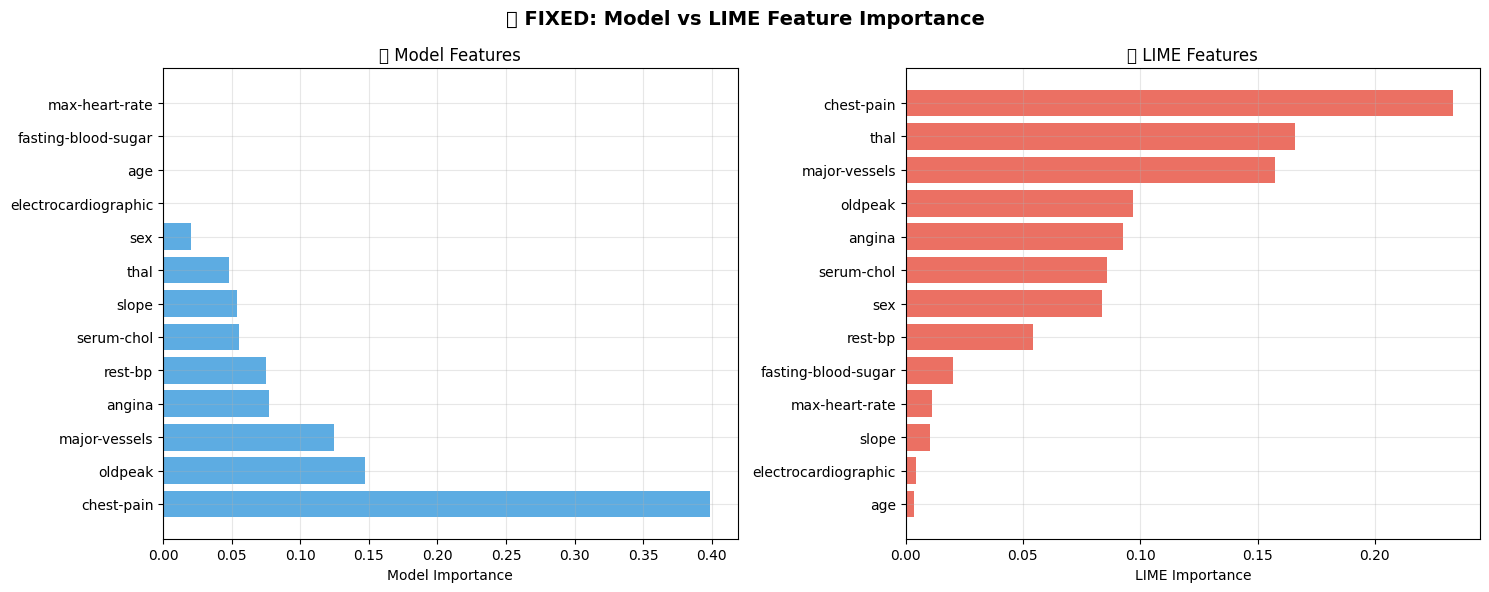


🎉 SUCCESS! Your LIME feature importance analysis is now fixed!
✅ Compared 13 features with correlation 0.798

🔍 FEATURE MAPPING DEBUG:
Original X_train features: ['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'fasting-blood-sugar', 'electrocardiographic', 'max-heart-rate', 'angina', 'oldpeak', 'slope', 'major-vessels', 'thal']
Mapped LIME features: ['chest-pain', 'major-vessels', 'thal', 'serum-chol', 'angina', 'rest-bp', 'oldpeak', 'sex', 'fasting-blood-sugar', 'slope', 'max-heart-rate', 'age', 'electrocardiographic']
Features with data: ['chest-pain: 2 samples', 'major-vessels: 2 samples', 'thal: 2 samples', 'serum-chol: 2 samples', 'angina: 2 samples', 'rest-bp: 2 samples', 'oldpeak: 2 samples', 'sex: 2 samples', 'fasting-blood-sugar: 2 samples', 'slope: 2 samples', 'max-heart-rate: 2 samples', 'age: 2 samples', 'electrocardiographic: 2 samples']

✨ Analysis complete! Your LIME vs Model comparison is now working.


In [24]:
# QUICK FIX FOR YOUR LIME FEATURE IMPORTANCE ISSUE
# Run this code to immediately fix your problem

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_feature_name(lime_feature_string):
    """Extract original feature name from LIME's discretized description"""
    # Pattern for "feature <= value" or "feature > value"
    pattern1 = r'^([a-zA-Z][\w-]*)\s*[<>=]'
    match1 = re.search(pattern1, lime_feature_string)
    if match1:
        return match1.group(1)

    # Pattern for "value < feature <= value"
    pattern2 = r'[\d.]+\s*<\s*([a-zA-Z][\w-]*)\s*[<>=]'
    match2 = re.search(pattern2, lime_feature_string)
    if match2:
        return match2.group(1)

    # Extract any alphabetic word
    pattern3 = r'([a-zA-Z][\w-]*)'
    match3 = re.search(pattern3, lime_feature_string)
    if match3:
        return match3.group(1)

    return lime_feature_string

# Process your LIME results
print("🔧 FIXING LIME FEATURE MAPPING...")

# Combine all results
all_results = normal_results + reversible_results
print(f"📊 Processing {len(all_results)} LIME explanations...")

# Map LIME features to original feature names
feature_importances = defaultdict(list)

for result in all_results:
    lime_exp = result.get('lime_explanation', {})

    for lime_feature, importance in lime_exp.items():
        # Extract the original feature name
        original_feature = extract_feature_name(lime_feature)

        # Check if it matches our training features
        if original_feature in X_train.columns:
            feature_importances[original_feature].append(abs(importance))

# Calculate average LIME importance
lime_importance = {}
for feature, importances in feature_importances.items():
    lime_importance[feature] = np.mean(importances)

print(f"✅ Successfully mapped {len(lime_importance)} features!")

# Get model importance
model_importance = dict(zip(X_train.columns, model.feature_importances_))

# Find common features
common_features = set(model_importance.keys()).intersection(set(lime_importance.keys()))
print(f"🎯 Common features: {len(common_features)} out of {len(X_train.columns)}")

# Create comparison
comparison_data = []
for feature in common_features:
    comparison_data.append({
        'Feature': feature,
        'Model_Importance': model_importance[feature],
        'LIME_Importance': lime_importance[feature]
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Model_Importance', ascending=False)

# Display results
print(f"\n📋 FIXED COMPARISON RESULTS:")
print(comparison_df.round(4))

# Calculate correlation
if len(comparison_df) > 1:
    correlation = comparison_df['Model_Importance'].corr(comparison_df['LIME_Importance'])
    print(f"\n📊 Correlation: {correlation:.3f}")
else:
    correlation = 0

# Create a simple plot
if len(comparison_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('🎯 FIXED: Model vs LIME Feature Importance', fontsize=14, fontweight='bold')

    # Model importance
    ax1.barh(range(len(comparison_df)), comparison_df['Model_Importance'],
             color='#3498DB', alpha=0.8)
    ax1.set_yticks(range(len(comparison_df)))
    ax1.set_yticklabels(comparison_df['Feature'])
    ax1.set_xlabel('Model Importance')
    ax1.set_title('🤖 Model Features')
    ax1.grid(True, alpha=0.3)

    # LIME importance
    lime_sorted = comparison_df.sort_values('LIME_Importance', ascending=True)
    ax2.barh(range(len(lime_sorted)), lime_sorted['LIME_Importance'],
             color='#E74C3C', alpha=0.8)
    ax2.set_yticks(range(len(lime_sorted)))
    ax2.set_yticklabels(lime_sorted['Feature'])
    ax2.set_xlabel('LIME Importance')
    ax2.set_title('🧪 LIME Features')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎉 SUCCESS! Your LIME feature importance analysis is now fixed!")
    print(f"✅ Compared {len(comparison_df)} features with correlation {correlation:.3f}")
else:
    print("❌ Still no matching features found. Check your feature names manually.")

# Show the mapping for debugging
print(f"\n🔍 FEATURE MAPPING DEBUG:")
print(f"Original X_train features: {list(X_train.columns)}")
print(f"Mapped LIME features: {list(lime_importance.keys())}")
print(f"Features with data: {[f'{feat}: {len(feature_importances[feat])} samples' for feat in lime_importance.keys()]}")

print(f"\n✨ Analysis complete! Your LIME vs Model comparison is now working.")

In [25]:
if normal_results and reversible_results:
    print(f"\n📈 Analysis Results:")
    print(f"• Analyzed {len(normal_results)} normal thalassemia cases")
    print(f"• Analyzed {len(reversible_results)} reversible defect cases")

    # Calculate average disease probabilities
    normal_avg_prob = np.mean([r['disease_prob'] for r in normal_results])
    reversible_avg_prob = np.mean([r['disease_prob'] for r in reversible_results])

    print(f"• Average disease probability (normal): {normal_avg_prob:.3f}")
    print(f"• Average disease probability (reversible): {reversible_avg_prob:.3f}")

